In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as calc_eigen
from sklearn.model_selection import train_test_split

In [107]:
def extractTrainAndTestData(file_path, r):
    """
    takes images and labels as input
    outputs training data and test data
    """
    mat = scipy.io.loadmat(file_path)
    X_train, X_test, y_train, y_test = train_test_split(mat['X'].T, mat['l'].T, test_size= r, random_state=19)
    N_train = len(X_train[:,0])
    N_test = len(X_test[:,0])
    return X_train, y_train, N_train, X_test, y_test, N_test

def calculateAverageFace(X):
    """
    takes the training data set as input 
    and returns the average face
    """
    average_face= np.mean(X, axis=0)
    #plt.figure()
    #plt.title("Average Face")
    #plt.imshow(np.resize(average_face, (46, 56)).T, cmap='gray')
    return average_face

def normalize(X, AvgFace):
    """
    takes the training data set and average face as input 
    and returns the normalized training data set

    """
    N = len(X[:,0])
    Q = np.empty((N,2576))
    for index, face in enumerate(X):
        Q[index] = face - AvgFace
    return Q.T

def calculateCovarianceMatrix(Q):
    return np.matmul(Q,Q.T)/len(Q[0,:])

def calculateEigenValuesAndVectors(S):
    """
    Takes covariance matrix as input
    and returns eigen values and vectors
    """
    v, w =  calc_eigen.eigh(S)
    #eigen_vectors[:,i] --> eigen_values[i]
    #eigen vector corresponding to eigen value

    #flips left to right... ascending to descending
    v = np.flip(v, axis=0) #turn ascending into descending
    w = np.flip(w, axis=1) #turn ascending into descending
    return v, w

def plotEigenValueGraph(v):
    y_points = [value for value in v]
    x_points = [i for i in range(len(v))]
    plt.plot(x_points, y_points)
    plt.show()
    
def calculateWeights(M, Q, U):
    N = len(Q[0,:])
    W = np.empty((N,M))
    for index, image in enumerate(Q.T):
        W[index] = np.matmul(image, U)
    return W

def calculateWeights2(M, Q, U):
    N = len(Q[0,:])
    W2 = np.empty((N,M))
    W2 = np.matmul(Q.T, top_eigen_vectors)
    return W2

def printImage(face):
    plt.figure()
    plt.imshow(np.resize(face, (46, 56)).T, cmap='gray')

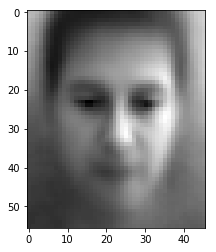

In [106]:
file_path = 'face(1).mat'
M = 200
testRatio = 0.20

X_train, y_train, N_train, X_test, y_test, N_test = extractTrainAndTestData(file_path, testRatio)

def calculateEigenSpace(X_train, M):
    AvgFace = calculateAverageFace(X_train)
    A = normalize(X_train, AvgFace)
    S = calculateCovarianceMatrix(A)
    eigen_values, eigen_vectors = calculateEigenValuesAndVectors(S)
    top_eigen_vectors = eigen_vectors[:, :M]
    return AvgFace, A, top_eigen_vectors

AvgFace, A, EigenSpace = calculateEigenSpace(X_train, M)
Weights =  calculateWeights(M, A, EigenSpace)

### Reconstruction

In [24]:
def reconstruction(weight, average_face, w):
    return (average_face + np.dot(w, weight.T))

In [25]:
# picking one face and it's corresponding weight for reconstruction
random_index = 5
face_to_be_reconstructed = X_train[random_index, :]
weights_of_face_to_be_reconstructed = Weights[random_index, :]

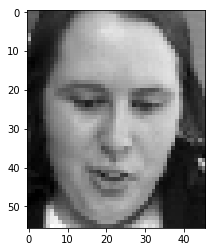

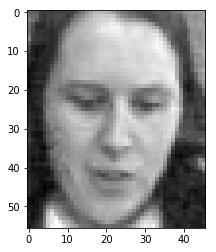

In [26]:
reconstructed_face = reconstruction(weights_of_face_to_be_reconstructed, AvgFace, EigenSpace)
printImage(face_to_be_reconstructed)
printImage(reconstructed_face)

### Recognition

In [27]:
def NNClassification(r, 
                     y_train, W_train, X_train, 
                     y_test, W_test, X_test):
    
    weight_test = W_test[r, :]
    face_test = X_test[r, :]
    face_test_label = y_test[r, :]
    error = np.empty(( len(W_train[:, 0]) ))
    for index, weight in enumerate(W_train): 
        error[index] = calc_eigen.norm(weight_test - weight)
    min_error = error.min()
    min_error_index = error.argmin()
    face_best_matched = X_train[min_error_index, :]
    label_best_matched = y_train[min_error_index, :]
    #print(face_test_label, '--->', label_best_matched)
    if label_best_matched != face_test_label:
        return 1
    else:
        return 0

In [28]:
A_test = normalize(X_test, AvgFace) #normalize the test data
W_test = calculateWeights(M, A_test, EigenSpace) #calculate weights of the test data 
totalErrors = 0
for r in range(N_test):
    totalErrors += NNClassification(r, y_train, Weights, X_train, y_test, W_test, X_test)
E_out = totalErrors/N_test
print(E_out*100)

39.42307692307692


### Alternative Recognition

In [135]:
noOfClasses = 52
reconstrErrors = np.empty((N_test, noOfClasses))
d = {}

for i in range(1, noOfClasses+1): #for each class    
    d["X_train_" + str(i)] = X_train[np.where(y_train == i)[0]]
    N = len(d["X_train_" + str(i)][:,0])
    AvgFace, normalized_Input, topEigenVectors = calculateEigenSpace(d["X_train_" + str(i)], M)
    #weights = calculateWeights(M, normalized_Input, topEigenVectors)
    weight_test = np.matmul(normalize(X_test, AvgFace).T, topEigenVectors)
    for index, weight in enumerate(weight_test):
        reconstructed_face = AvgFace + np.dot(topEigenVectors, weight.T)
        reconstruction_error = calc_eigen.norm(X_test[index] - reconstructed_face)
        reconstrErrors[index, i-1] = reconstruction_error 

In [136]:
total_error = 0
for index, face in enumerate(reconstrErrors):
    original_class = y_test[index, :]
    min_error = face.min()
    min_error_index = face.argmin()
    #print(original_class, '-->', min_error_index+1)
    class_matched = min_error_index+1
    if original_class != class_matched:
        total_error +=1

In [134]:
total_error*100/N_test

26.923076923076923